In [1]:
%cd ..

/home/chickencurry/emb-ml-challenge


In [2]:
import tqdm
import copy
import torch
from typing import Dict, List
import numpy as np
from utils.tinyyolov2 import TinyYoloV2Pruned
from utils.loss import YoloLoss
from utils.dataloader import VOCDataLoaderPerson
from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes
from utils.utils import net_acc, net_time, net_macs, plot

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
import torch_directml
device = torch_directml.device()
print(device)

privateuseone:0


In [5]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float, ignored_n: List[int]) -> Dict:
    state_dict = copy.deepcopy(state_dict)

    mask_dict = {}
    
    for key, value in state_dict.items():
        n = key.split(".")[0][-1]  
        n = int(n) if n.isdigit() else None

        if n is None or n in ignored_n:
            continue
        
        if "conv" in key and "weight" in key:
            norms = value.flatten(1).norm(p=1, dim=1)
            percentile = np.percentile(norms, prune_ratio * 100)
            mask = (norms >= percentile)
            state_dict[key] = value * mask[:, None, None, None]
            mask_dict[n] = mask

    for n in range(1, 9):
        if n in ignored_n:
            continue
        
        keys = [f"bn{n}.weight", f"bn{n}.bias", f"bn{n}.running_mean", f"bn{n}.running_var"]
        for key in keys:
            state_dict[key] = state_dict[key] * mask_dict[n]
    
    return state_dict

In [6]:
def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    indices_dict = {}
    
    for key, value in state_dict.items():
        if "conv" in key and "weight" in key:

            n = key.split(".")[0][-1]  
            n = int(n) if n.isdigit() else None

            if n is not None and n-1 in indices_dict:
                value = value[:, indices_dict[n-1], :, :]
                
            summed = value.flatten(1).abs().sum(1)
            indices = summed.nonzero().flatten()
            value = value[indices, :, :, :]
            state_dict[key] = value

            indices_dict[n] = indices
        
        elif "bn" in key and "num_batches_tracked" not in key:
            indices = value.nonzero().flatten()
            value = value[indices]
            state_dict[key] = value
    
    return state_dict

In [7]:
ratio = 0.3
state_dict = torch.load('./runs/voc_person_only.pt')
state_dict = l1_structured_pruning(state_dict, ratio, [9])
state_dict = densify_state_dict(state_dict)

In [8]:
net = TinyYoloV2Pruned(num_classes=1)
net.load_state_dict(state_dict, strict=False)
net = net.to(device)
net.eval()

TinyYoloV2Pruned(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(11, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(22, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(45, 89, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(89, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(89, 179, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(179, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(179, 358, kernel_size=(3, 3), stri

In [9]:
loader_test = VOCDataLoaderPerson(train=False, batch_size=1)

100%|██████████| 350/350 [00:30<00:00, 11.46it/s]


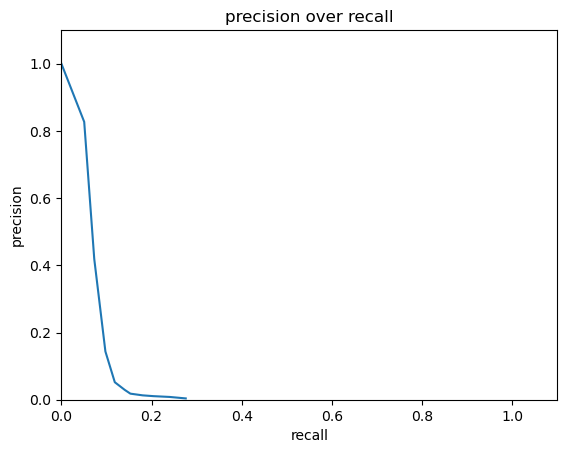

In [11]:
NUM_TEST_SAMPLES = 350

test_precision = []
test_recall = []

with torch.no_grad():
    for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=NUM_TEST_SAMPLES):
        input = input.to(device)
        output = net(input).cpu()

        #The right threshold values can be adjusted for the target application
        output = filter_boxes(output, 0.0)
        output = nms(output, 0.5)

        precision, recall = precision_recall_levels(target[0], output[0])
        test_precision.append(precision)
        test_recall.append(recall)

        if idx == NUM_TEST_SAMPLES:
            break

#plot ROC
display_roc(test_precision, test_recall)

In [13]:
torch.save(net.state_dict(), "runs/voc_person_only_pruned.pt")